# Tutorial on Electron Density Regression

Here we will fit a set of crystals and their electronic structure with several methods and then compare their accuracies.

In [1]:
%matplotlib notebook
import parsers
import fitelectrondensity as fed
import numpy as np
import time, itertools
from scipy import stats
import pandas as pd
from fitelectrondensity.linear_model import RelevanceVectorMachine, distribution_wrapper
import matplotlib.pylab as plt
from sklearn import metrics, linear_model

E:\Programs\Anaconda3\envs\py35\lib\site-packages\ase\lattice\spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


### 1. Parse Some DFT Structures

In [2]:
dft_path = "./tests/unittest_files/castep/"
#dft_path = "./tests/unittest_files/profess/"

# parsing DFT files
gip = parsers.general.GeneralInputParser(verbose=False)
gip.parse_all(dft_path)
gip.sort()

### 2. Setting up the Design Matrix $\boldsymbol{\Phi}$

In [3]:
# density point selection
## first tuple entry specifies selection type, following fix specifics, i.e.("random",10.) mean select 10% of all points uniformly at random 
# selection = ("atom",.5,"r") # selects within .5 Angstrom spherically around every atom
selection = ("importance_mag",10.,"relative")

# info for bonds
num_neigh = None # number of neighoring atoms for (ghost) atom
r_cut = 6.
aniso = False
ultra_num = None #number of additional super cells in each sim box vector direction
seed = 42
np.random.seed(seed=seed)

# info for basis set
k_iso=50 # parameter for iso basis size
k_ani= 5 # parameter for ani basis size
type_iso="Fourier" # type of basis for iso
type_ani="Fourier" # type of basis for ani
smooth = True # apply smoothing of basis functions towards r_smooth
r_smooth = r_cut
r_scale = r_cut
self_contribution = True # whether or not an atom itself is considered contribution to the valence elenctron density
f_smooth = .1 # fudge factor for smoothing

ani_type = "MEAM" # "MEAM", BOP, BOP-r or BOP-invr, "R", "BOP4atoms", "BOP4atoms-ref", "BOP4atoms-ref2", "BOP-taper1"    
ani_specification = {"l_range": np.array([4,6,8],dtype=int),
                     "usage":"everything","r_ani":4.} #"usage": "everything" (is "usage" is not present this is assumed as default, all" and aphabetically sorted elements), "all" (only use q obtained for "all"), "Ni" (only usq q obtained for "Ni")

# Fortran usage (only under Linux)
usefortran = False

bonds = []
print("Generating bonds for ...")
t0 = time.time()
for tmp_gip in gip:
    print("{}...".format(tmp_gip.get_name()))
    tmp_bonds = fed.misc.get_observations(tmp_gip, ultra_num=ultra_num, 
                                          num_neigh=num_neigh, r_cut=r_cut, aniso=aniso,
                                          verbose=False, selection=selection, seed=seed,
                                          ani_type=ani_type, ani_specification=ani_specification)
    bonds.extend(tmp_bonds)
print("generated bonds {}s...".format(time.time()-t0))

# setup the basis and the corresponding mapper
basis, mapper = fed.rvm.get_basis(gips=[gip], k_iso=k_iso, k_ani=k_ani,\
        type_iso=type_iso, type_ani=type_ani, smooth=smooth, r_smooth=r_smooth,\
        f_smooth=f_smooth, verbose=True,self_contribution=self_contribution, aniso=aniso,\
        rcut=r_cut, num_neigh=num_neigh, r_scale=r_scale, ani_type=ani_type, ani_specification=ani_specification)

# setup the design matrix
Phi, t = fed.rvm.get_design_matrix(bonds, basis, mapper, verbose=False,
                                   return_t=True, seed=seed, usefortran=usefortran)

Generating bonds for ...
A1...
Found all cells for r_cut 6.0 => r_search = 14.15 Ang, terminating after 7 iterations
A2...
Found all cells for r_cut 6.0 => r_search = 12.95 Ang, terminating after 6 iterations
A3...
Found all cells for r_cut 6.0 => r_search = 14.03 Ang, terminating after 6 iterations
Al_100K-321...
Found all cells for r_cut 6.0 => r_search = 19.53 Ang, terminating after 3 iterations
Al_4d05...
Found all cells for r_cut 6.0 => r_search = 14.27 Ang, terminating after 4 iterations


E:\PetProjects\Empirical Potentials\PottyTrainer\pottytrainer\fitelectrondensity\misc.py:398: RuntimeWarning: invalid value encountered in true_divide
  r_vec /= np.reshape(r["all"],(-1,1))


Ni3Al_1x1x1...
Found all cells for r_cut 6.0 => r_search = 13.99 Ang, terminating after 4 iterations
Ni3Al_1x1x1_dis...
Found all cells for r_cut 6.0 => r_search = 13.99 Ang, terminating after 4 iterations
generated bonds 4.873323202133179s...
Generating basis...
k_ani 5 => k_ani_dict {'unlike': {'theta': 5, 'r': 5}, 'like': {'theta': 5, 'r': 5}}
species ['Al', 'Ni']
pairs [('Al', 'Al'), ('Al', 'Ni'), ('Ni', 'Ni')]
species present ['Al', 'Ni']...
ansio type is : Fourier
finalized basis with 2 terms...
Generating design matrix for 18060 samples...
mapping >> s Al, ix_s 0, ix_e 50
mapping >> s Ni, ix_s 50, ix_e 100


### 3. RVM Regression #1

Using the first of the two implemented versions of the RVM regression method.

In [4]:
# RVM initiate hyper parameters
niter = 250
tol = 1e-6
fix_beta = False
n_steps_beta = 1 # integer specifying every nth step to update beta
sequential = False
stochastic = ("all",) # ("all",), ("uniform",5000) switch for rvm.get_design_matrix, specifies how many and which observations from the ones already processed are actually used in a given run 
niter_stochastic = 1 # number of iterations generating new Phis according to variable 'stochastic' if stochastic[0] != "all"

N,M = Phi.shape
print("M = {} N = {}".format(N,M))
alpha_init = np.ones(M)
alpha_init[1:] = np.inf
beta_init = 1./t.var()

logbook = fed.rvm.iterate(Phi, t, niter=niter, verbose=False, alpha_init=alpha_init,
            beta_init=beta_init, tol=tol, fix_beta=fix_beta, sequential=sequential,
            n_steps_beta=n_steps_beta, seed=seed)

M = 18060 N = 100
Starting RVM iteration...
time spent on:
Sigma 0 s...
weights 0.12236976623535156 s...
qualities 0.27798914909362793 s...
hyperparameters 0 s...


### 4. RVM Regression #2

Using the other implemented versions of the RVM regression method. This version is newer and contains some upgrades, e.g. initial hyperparameters can be passed in form of scipy.stats distriutions and one can pass a customized convergence condition as well as select the number of alpha hyperparameters being evaluated at ever iteration.

In [5]:
init_beta = distribution_wrapper(stats.halfnorm(scale=1),size=1,single=True)
init_alphas = distribution_wrapper(stats.halfnorm(scale=1),single=False)

model_kwargs = dict(n_iter=250,verbose=False,compute_score=True,init_beta=init_beta,
                            init_alphas=init_alphas)
model = RelevanceVectorMachine(**model_kwargs)
model.fit(Phi,t.ravel())

RelevanceVectorMachine(beta_every=1, compute_score=True,
            convergence_condition=None, copy_X=True, do_logbook=False,
            fit_intercept=False,
            init_alphas=<function distribution_wrapper.<locals>.samples at 0x000002BCE1955598>,
            init_beta=<function distribution_wrapper.<locals>.samples at 0x000002BCE3CCFC80>,
            n_iter=250, normalize=False, tol=0.001, update_pct=1.0,
            verbose=False)

In [6]:
print("beta(electron density) = {:.4f}".format(1./np.var(t.ravel())))
print("beta(RVM#1) = {:.4f}".format(logbook["beta"][-1]))
print("beta(RVM#2) = {:.4f}".format(model.beta_))

beta(electron density) = 0.4928
beta(RVM#1) = 4110.9122
beta(RVM#2) = 4113.6230


<IPython.core.display.Javascript object>


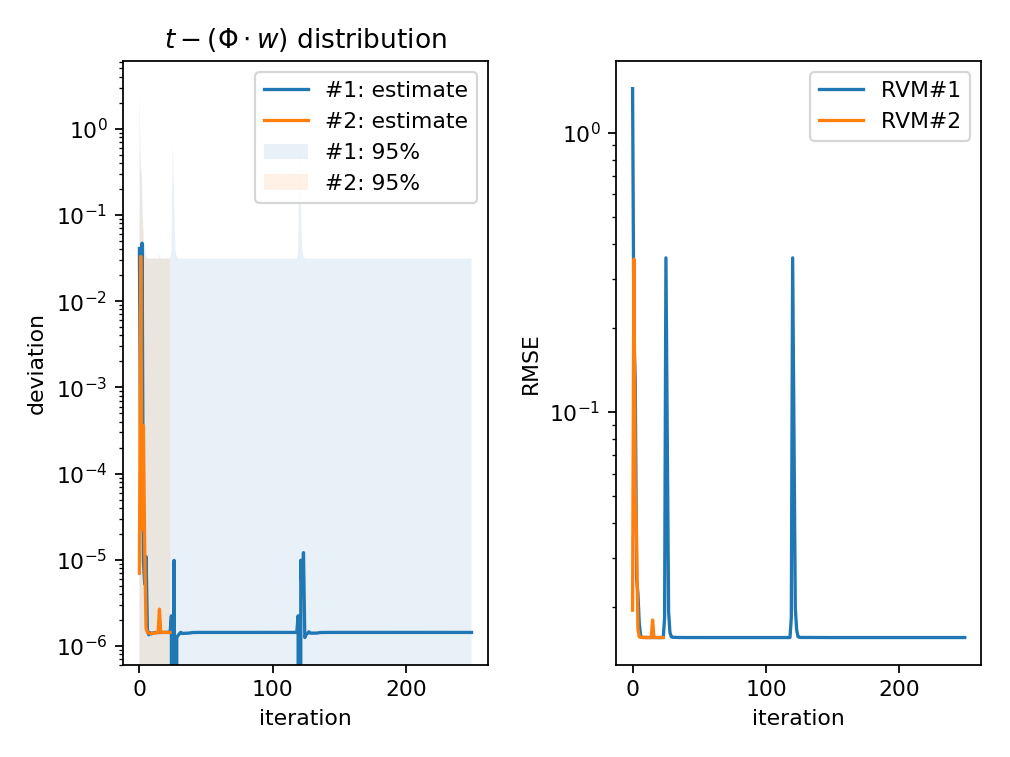

In [7]:
_y = np.array(logbook["dev_est"])
_x = np.arange(_y.shape[0])
_yerr = 2.*np.array(logbook["dev_std"])

_y1 = np.array(model.dev_est)
_x1 = np.arange(_y1.shape[0])
_yerr1 = 2.*np.array(model.dev_std)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.fill_between(_x,_y-_yerr,_y+_yerr,alpha=.1,label="#1: 95%")
ax.plot(_x,_y,'-',label="#1: estimate")
ax.fill_between(_x1,_y1-_yerr1,_y1+_yerr1,alpha=.1,label="#2: 95%")
ax.plot(_x1,_y1,'-',label="#2: estimate")
ax.set_xlabel("iteration")
ax.set_ylabel("deviation")
ax.set_yscale("log")
ax.set_title("$t- (\Phi \cdot w)$ distribution")
plt.legend(loc=0)

ax2 = fig.add_subplot(122)
ax2.plot(np.sqrt(logbook["mse"]),label="RVM#1")
ax2.plot(np.sqrt(model.mse_),label="RVM#2")
ax2.set_xlabel("iteration")
ax2.set_ylabel("RMSE")
ax2.set_yscale("log")
plt.legend(loc=0)
plt.tight_layout()
plt.show()

### 5. Regressing with a range of scikit-learn's methods

Note that the non Bayesian methods require hyperparameter optimization for best performance, unlike the default falues as used below. 

List of linear model methods: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

List of metrics: http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [8]:
init_beta = distribution_wrapper(stats.halfnorm(scale=1),size=1,single=True)
init_alphas = distribution_wrapper(stats.halfnorm(scale=1),single=False)

n_iter = 250
rvm_model_kwargs = dict(n_iter=n_iter,verbose=False,compute_score=False,init_beta=init_beta,
                            init_alphas=init_alphas)
model_kwargs = dict(n_iter=n_iter,verbose=False)

model_types = {"BayesianRidge":linear_model.BayesianRidge(**model_kwargs),
               "LinearRegression":linear_model.LinearRegression(),
               "RVM#2":RelevanceVectorMachine(**rvm_model_kwargs),
               "ElasticNet":linear_model.ElasticNet(max_iter=n_iter),
               "HuberRegressor":linear_model.HuberRegressor(max_iter=n_iter),
               "Lars":linear_model.Lars(),
               "Lasso":linear_model.Lasso(max_iter=n_iter),
               "LassoLars":linear_model.LassoLars(max_iter=n_iter),
               "LassoLarsIC":linear_model.LassoLarsIC(max_iter=n_iter),
               "OrthogonalMatchingPursuit":linear_model.OrthogonalMatchingPursuit(),
               "Ridge":linear_model.Ridge(max_iter=n_iter),
               "SGDRegressor":linear_model.SGDRegressor(),
               "TheilSenRegressor":linear_model.TheilSenRegressor(max_iter=n_iter),
               }
#"ARDRegression":linear_model.ARDRegression(**model_kwargs), # ARDRegression is super slow

metric_types = {"r2_score":metrics.r2_score,
                "mean_squared_error":metrics.mean_squared_error,
                "explained_variance_score":metrics.explained_variance_score,
                "mean_absolute_error":metrics.mean_absolute_error,
                "median_absolute_error":metrics.median_absolute_error}
#,"mean_squared_log_error":metrics.mean_squared_log_error,

scores = {(_model,_metric): None for _model,_metric in itertools.product(model_types,metric_types)}

for _model in model_types:
    print("regressing with {} ...".format(_model))
    t0 = time.time()
    model_types[_model].fit(Phi,t.ravel())
    print("{:.4f} s...".format(time.time()-t0))
    
print("scoring...")
for (_model,_metric) in scores:
    scores[(_model,_metric)] = metric_types[_metric](t.ravel(),model_types[_model].predict(Phi))

E:\Programs\Anaconda3\envs\py35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


regressing with Ridge ...
0.1250 s...
regressing with HuberRegressor ...
4.5580 s...
regressing with Lars ...
0.0727 s...
regressing with OrthogonalMatchingPursuit ...
0.0361 s...
regressing with SGDRegressor ...
0.0406 s...
regressing with Lasso ...
0.0506 s...
regressing with LassoLarsIC ...
0.2146 s...
regressing with ElasticNet ...
0.0592 s...
regressing with RVM#2 ...
1.0230 s...
regressing with TheilSenRegressor ...
19.4271 s...
regressing with BayesianRidge ...
0.0737 s...
regressing with LinearRegression ...
0.0507 s...
regressing with LassoLars ...
0.0346 s...
scoring...


### 6. Compare the Regression Methods

In [9]:
def rank_model_type_by_metric(scores,metric="r2_score",reverse=False):
    s = "Metric: {}".format(metric)
    print("\n"+"="*len(s))
    print(s)
    print("-"*len(s))
    
    models_and_scores = sorted([(_key[0],_val) for _key, _val in scores.items() if _key[1]==metric],\
                               key=lambda k: k[1],reverse=reverse)
    
    df = pd.DataFrame.from_records(models_and_scores,columns=["Model type",metric])
    print(df)
    
rank_model_type_by_metric(scores,metric="r2_score",reverse=True)
rank_model_type_by_metric(scores,metric="mean_squared_error",reverse=False)
rank_model_type_by_metric(scores,metric="explained_variance_score",reverse=True)
rank_model_type_by_metric(scores,metric="mean_absolute_error",reverse=False)
rank_model_type_by_metric(scores,metric="median_absolute_error",reverse=False)


Metric: r2_score
----------------
                   Model type      r2_score
0            LinearRegression  9.998808e-01
1               BayesianRidge  9.998808e-01
2                       RVM#2  9.998808e-01
3                       Ridge  9.998275e-01
4                 LassoLarsIC  9.992007e-01
5   OrthogonalMatchingPursuit  8.490745e-01
6              HuberRegressor  6.753951e-01
7           TheilSenRegressor  6.731194e-01
8                  ElasticNet  6.488586e-01
9                       Lasso  4.758706e-01
10                  LassoLars  0.000000e+00
11                       Lars -7.338408e+09
12               SGDRegressor -2.742048e+23

Metric: mean_squared_error
--------------------------
                   Model type  mean_squared_error
0            LinearRegression        2.417966e-04
1               BayesianRidge        2.417980e-04
2                       RVM#2        2.419533e-04
3                       Ridge        3.500856e-04
4                 LassoLarsIC        1.62196